In [ ]:
!nvidia-smi          # confirm T4 GPU is active
!pip install -q timm==0.9.2 scikit-learn matplotlib


Wed Oct 29 08:47:55 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os, glob, shutil, random, time, copy
import numpy as np
import torch, timm
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# 🔧 CONFIG
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DATA_SRC = '/content/dataset/seg_train/seg_train'  # change if different
DATA_DIR = '/content/dataset'            # where we'll create train/val/test
IMG_SIZE = 224
BATCH = 32
SEED = 42
print("Using device:", DEVICE)


Using device: cuda


In [ ]:
from sklearn.model_selection import train_test_split

random.seed(SEED)
os.makedirs(DATA_DIR, exist_ok=True)
classes = [d for d in os.listdir(DATA_SRC) if os.path.isdir(os.path.join(DATA_SRC, d))]
print("Found classes:", classes)

for cls in classes:
    files = glob.glob(os.path.join(DATA_SRC, cls, '*'))
    train, rest = train_test_split(files, test_size=0.2, random_state=SEED)
    val, test = train_test_split(rest, test_size=0.5, random_state=SEED)
    for split, fset in [('train', train), ('val', val), ('test', test)]:
        outdir = os.path.join(DATA_DIR, split, cls)
        os.makedirs(outdir, exist_ok=True)
        for f in fset:
            shutil.copy(f, os.path.join(outdir, os.path.basename(f)))

for split in ['train','val','test']:
    count = sum(len(files) for _,_,files in os.walk(os.path.join(DATA_DIR, split)))
    print(split, ":", count, "images")


Found classes: ['street', 'glacier', 'forest', 'sea', 'mountain', 'buildings']
train : 11224 images
val : 1402 images
test : 1408 images


In [ ]:
!ls -R /content/dataset | head -n 40


/content/dataset:
seg_pred
seg_test
seg_train
test
train
val

/content/dataset/seg_pred:
seg_pred

/content/dataset/seg_pred/seg_pred:
10004.jpg
10005.jpg
10012.jpg
10013.jpg
10017.jpg
10021.jpg
10034.jpg
10038.jpg
1003.jpg
10040.jpg
10043.jpg
10045.jpg
10047.jpg
10048.jpg
10052.jpg
10054.jpg
10059.jpg
10060.jpg
10066.jpg
10069.jpg
10073.jpg
10079.jpg
10082.jpg
10083.jpg
1008.jpg
10090.jpg
10092.jpg
10096.jpg


In [ ]:
from google.colab import files
uploaded = files.upload()  # Choose your ZIP file (e.g. archive.zip)


KeyboardInterrupt: 

In [ ]:
!ls /content


'archive (6).zip'   dataset   drive   sample_data


In [ ]:
!mkdir -p /content/dataset
!unzip -q "/content/archive (6).zip" -d /content/dataset
!ls /content/dataset


replace /content/dataset/seg_pred/seg_pred/10004.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: seg_pred  seg_test  seg_train  test  train  val


In [ ]:
!ls -R /content/dataset | head -n 50



/content/dataset:
seg_pred
seg_test
seg_train
test
train
val

/content/dataset/seg_pred:
seg_pred

/content/dataset/seg_pred/seg_pred:
10004.jpg
10005.jpg
10012.jpg
10013.jpg
10017.jpg
10021.jpg
10034.jpg
10038.jpg
1003.jpg
10040.jpg
10043.jpg
10045.jpg
10047.jpg
10048.jpg
10052.jpg
10054.jpg
10059.jpg
10060.jpg
10066.jpg
10069.jpg
10073.jpg
10079.jpg
10082.jpg
10083.jpg
1008.jpg
10090.jpg
10092.jpg
10096.jpg
10100.jpg
10101.jpg
10102.jpg
10106.jpg
10109.jpg
10119.jpg
10124.jpg
10127.jpg
10129.jpg
10132.jpg


In [ ]:
# move the inner seg_train up one level
!mv /content/dataset/seg_train/seg_train /content/dataset/seg_train_fixed
!rm -rf /content/dataset/seg_train
!mv /content/dataset/seg_train_fixed /content/dataset/seg_train

# verify
!ls /content/dataset/seg_train


buildings  forest  glacier  mountain  sea  street


In [ ]:
DATA_SRC = '/content/dataset/seg_train'


In [ ]:
import os
print(os.listdir(DATA_SRC))


['street', 'glacier', 'forest', 'sea', 'mountain', 'buildings']


In [ ]:
# Smart auto-check + fix + split cell
import os, glob, shutil, random
from sklearn.model_selection import train_test_split

random_seed = 42
SRC_ROOT = '/content/dataset'          # where you unzipped archive
OUT_ROOT = '/content/dataset_split'    # where split dataset will be created
IMG_EXTS = ('.jpg', '.jpeg', '.png')

def is_class_folder(path):
    # Heuristic: folder contains image files or subfolders that contain images
    try:
        entries = os.listdir(path)
    except Exception:
        return False
    # if many image files directly inside, treat as images folder (not class folder)
    img_files = [f for f in entries if f.lower().endswith(IMG_EXTS)]
    if img_files:
        return False
    # if subfolders exist and those subfolders contain images, this is parent-of-classes
    subdirs = [d for d in entries if os.path.isdir(os.path.join(path, d))]
    if not subdirs:
        return False
    for sd in subdirs:
        sd_path = os.path.join(path, sd)
        # check if subdir contains images
        for root,_,files in os.walk(sd_path):
            if any(f.lower().endswith(IMG_EXTS) for f in files):
                return True
    return False

# Step A: find candidate directories that contain classes
candidates = []
for root, dirs, files in os.walk(SRC_ROOT):
    # only immediate children level considered
    if root.count(os.sep) - SRC_ROOT.count(os.sep) > 2:
        # skip deep recursion to speed up
        continue
    if is_class_folder(root):
        candidates.append(root)

# If none found, try simpler heuristics
if not candidates:
    # check immediate children of SRC_ROOT
    for name in os.listdir(SRC_ROOT):
        p = os.path.join(SRC_ROOT, name)
        if os.path.isdir(p):
            # if that dir contains class-named subfolders (folders that contain images), pick it
            subdirs = [d for d in os.listdir(p) if os.path.isdir(os.path.join(p, d))]
            if any(len(glob.glob(os.path.join(p, sd, '*'+ext)))>0 for sd in subdirs for ext in IMG_EXTS):
                candidates.append(p)
    # fallback: if SRC_ROOT itself contains class folders directly (folders with images)
    if not candidates:
        subdirs = [d for d in os.listdir(SRC_ROOT) if os.path.isdir(os.path.join(SRC_ROOT, d))]
        if any(len(glob.glob(os.path.join(SRC_ROOT, sd, '*'+ext)))>0 for sd in subdirs for ext in IMG_EXTS):
            candidates.append(SRC_ROOT)

if not candidates:
    print("❌ Could not find image class folders under", SRC_ROOT)
    print("Run `!ls -R /content/dataset` to inspect manually or upload/unzip dataset into /content/dataset.")
    raise SystemExit

# If multiple candidates, pick the one with most image files
best = max(candidates, key=lambda p: sum(len(glob.glob(os.path.join(p, d, '*'+ext))) for d in os.listdir(p) if os.path.isdir(os.path.join(p,d)) for ext in IMG_EXTS))
print("✅ Detected class-parent folder:", best)

# If best is nested like /content/dataset/seg_train/seg_train, ensure we use inner that contains classes
# best already points to folder whose subdirs contain image files.

DATA_SRC = best
print("Using DATA_SRC =", DATA_SRC)
print("Classes found:")
classes = sorted([d for d in os.listdir(DATA_SRC) if os.path.isdir(os.path.join(DATA_SRC, d))])
print(classes)

# Create split (80/10/10)
os.makedirs(OUT_ROOT, exist_ok=True)
train_count = val_count = test_count = 0

for cls in classes:
    cls_dir = os.path.join(DATA_SRC, cls)
    img_files = [f for f in glob.glob(os.path.join(cls_dir, '*')) if f.lower().endswith(IMG_EXTS)]
    img_files = sorted(img_files)
    if len(img_files) == 0:
        print(f"⚠️ No images found for class {cls}, skipping.")
        continue
    train_files, rest = train_test_split(img_files, test_size=0.2, random_state=random_seed)
    val_files, test_files = train_test_split(rest, test_size=0.5, random_state=random_seed)
    for split_name, fileset in [('train', train_files), ('val', val_files), ('test', test_files)]:
        out_dir = os.path.join(OUT_ROOT, split_name, cls)
        os.makedirs(out_dir, exist_ok=True)
        for f in fileset:
            shutil.copy(f, os.path.join(out_dir, os.path.basename(f)))
    train_count += len(train_files)
    val_count += len(val_files)
    test_count += len(test_files)

print(f"\n🎯 Split complete. Totals -> train: {train_count}, val: {val_count}, test: {test_count}")
print("\nSample directory tree (top levels):")
!ls -R /content/dataset_split | sed -n '1,200p'


✅ Detected class-parent folder: /content/dataset/seg_train
Using DATA_SRC = /content/dataset/seg_train
Classes found:
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

🎯 Split complete. Totals -> train: 11224, val: 1402, test: 1408

Sample directory tree (top levels):
/content/dataset_split:
test
train
val

/content/dataset_split/test:
buildings
forest
glacier
mountain
sea
street

/content/dataset_split/test/buildings:
10151.jpg
10210.jpg
10374.jpg
10495.jpg
10502.jpg
10576.jpg
10582.jpg
10608.jpg
10865.jpg
10924.jpg
10936.jpg
11045.jpg
1107.jpg
11187.jpg
11530.jpg
1161.jpg
11642.jpg
11670.jpg
11788.jpg
11845.jpg
11855.jpg
12000.jpg
12060.jpg
12063.jpg
12160.jpg
1221.jpg
12391.jpg
12393.jpg
12427.jpg
12432.jpg
12494.jpg
12500.jpg
12536.jpg
12540.jpg
12543.jpg
12632.jpg
12659.jpg
12744.jpg
12818.jpg
12827.jpg
12925.jpg
13079.jpg
13131.jpg
13253.jpg
13276.jpg
13284.jpg
1333.jpg
13463.jpg
13472.jpg
13474.jpg
13490.jpg
13540.jpg
13599.jpg
13746.jpg
13835.jpg
13982.jpg
139.jp

In [ ]:
DATA_DIR = '/content/dataset_split'


In [ ]:
# Verify dataset_split structure & counts
import os, glob
DATA_DIR = '/content/dataset_split'
for split in ['train','val','test']:
    root = os.path.join(DATA_DIR, split)
    classes = sorted([d for d in os.listdir(root) if os.path.isdir(os.path.join(root,d))])
    total = sum(len(glob.glob(os.path.join(root,c,'*'))) for c in classes)
    print(f"{split}: {total} images, classes: {classes[:10]}")


train: 11224 images, classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
val: 1402 images, classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
test: 1408 images, classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [ ]:
# Transforms and dataloaders
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
IMG_SIZE = 224
BATCH = 32         # reduce to 16 if OOM on T4
NUM_WORKERS = 2

train_tfm = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.05),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_tfm = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

train_ds = datasets.ImageFolder(os.path.join(DATA_DIR,'train'), transform=train_tfm)
val_ds   = datasets.ImageFolder(os.path.join(DATA_DIR,'val'),   transform=val_tfm)
test_ds  = datasets.ImageFolder(os.path.join(DATA_DIR,'test'),  transform=val_tfm)

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

class_names = train_ds.classes
print("Classes:", class_names)
print("Train/Val/Test sizes:", len(train_ds), len(val_ds), len(test_ds))


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Train/Val/Test sizes: 11224 1402 1408


In [ ]:
# Two-stage train: EfficientNet-B0 via timm
import torch, timm, copy, time, numpy as np
import torch.nn as nn, torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model = timm.create_model('tf_efficientnet_b0_ns', pretrained=True, num_classes=len(class_names))
model.to(DEVICE)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

# Stage 1: head-only
for name, p in model.named_parameters():
    p.requires_grad = False
for name, p in model.named_parameters():
    if 'classifier' in name or 'head' in name or 'fc' in name:
        p.requires_grad = True

opt = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3, weight_decay=1e-4)
sched = optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=3)
E1 = 6
best_val_acc = 0.0
best_state = None
SAVE_PATH = '/content/best_model.pth'

def run_epoch(loader, train=True):
    if train: model.train()
    else: model.eval()
    running_loss = 0.0; preds=[]; targs=[]
    for imgs, labels in loader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        if train: opt.zero_grad()
        with torch.set_grad_enabled(train):
            logits = model(imgs)
            loss = criterion(logits, labels)
            if train:
                loss.backward(); opt.step()
        running_loss += loss.item()*imgs.size(0)
        preds.extend(torch.argmax(logits,1).cpu().tolist())
        targs.extend(labels.cpu().tolist())
    avg_loss = running_loss/len(loader.dataset)
    acc = (np.array(preds)==np.array(targs)).mean()
    return avg_loss, acc

for epoch in range(1, E1+1):
    t0=time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader, train=False)
    sched.step(val_loss)
    print(f"[Stage1] Epoch {epoch}/{E1} tr_acc={tr_acc:.4f} val_acc={val_acc:.4f} time={time.time()-t0:.1f}s")
    if val_acc>best_val_acc:
        best_val_acc=val_acc; best_state=copy.deepcopy(model.state_dict()); torch.save({'model_state':best_state,'class_names':class_names}, SAVE_PATH)

# Stage 2: unfreeze all & fine tune
for p in model.parameters(): p.requires_grad = True
opt = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-4)
sched2 = optim.lr_scheduler.CosineAnnealingLR(opt, T_max=20)
E2 = 25
patience = 7; noimp=0

for epoch in range(1, E2+1):
    t0=time.time()
    tr_loss, tr_acc = run_epoch(train_loader, train=True)
    val_loss, val_acc = run_epoch(val_loader, train=False)
    sched2.step()
    print(f"[Stage2] Epoch {epoch}/{E2} tr_acc={tr_acc:.4f} val_acc={val_acc:.4f} time={time.time()-t0:.1f}s")
    if val_acc>best_val_acc:
        best_val_acc=val_acc; best_state=copy.deepcopy(model.state_dict()); torch.save({'model_state':best_state,'class_names':class_names}, SAVE_PATH); noimp=0
    else:
        noimp+=1
    if noimp>=patience:
        print("Early stopping")
        break

print("Best val acc:", best_val_acc)


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(
/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

[Stage1] Epoch 1/6 tr_acc=0.7907 val_acc=0.8195 time=97.3s
[Stage1] Epoch 2/6 tr_acc=0.8474 val_acc=0.8573 time=91.9s
[Stage1] Epoch 3/6 tr_acc=0.8698 val_acc=0.8588 time=89.4s
[Stage1] Epoch 4/6 tr_acc=0.8856 val_acc=0.8773 time=89.2s
[Stage1] Epoch 5/6 tr_acc=0.8949 val_acc=0.8887 time=89.7s
[Stage1] Epoch 6/6 tr_acc=0.9080 val_acc=0.8859 time=89.6s
[Stage2] Epoch 1/25 tr_acc=0.9325 val_acc=0.9158 time=100.5s
[Stage2] Epoch 2/25 tr_acc=0.9494 val_acc=0.9058 time=99.8s
[Stage2] Epoch 3/25 tr_acc=0.9517 val_acc=0.9215 time=101.2s
[Stage2] Epoch 4/25 tr_acc=0.9632 val_acc=0.9280 time=99.9s
[Stage2] Epoch 5/25 tr_acc=0.9662 val_acc=0.9315 time=100.6s
[Stage2] Epoch 6/25 tr_acc=0.9697 val_acc=0.9301 time=100.1s
[Stage2] Epoch 7/25 tr_acc=0.9755 val_acc=0.9365 time=98.6s
[Stage2] Epoch 8/25 tr_acc=0.9795 val_acc=0.9315 time=98.9s
[Stage2] Epoch 9/25 tr_acc=0.9800 val_acc=0.9315 time=99.0s
[Stage2] Epoch 10/25 tr_acc=0.9840 val_acc=0.9287 time=98.5s
[Stage2] Epoch 11/25 tr_acc=0.9872 val_ac

In [ ]:
# load best and evaluate
ckpt = torch.load('/content/best_model.pth', map_location=DEVICE)
model.load_state_dict(ckpt['model_state'])
model.eval()

all_preds=[]; all_targs=[]
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        all_preds += logits.argmax(1).cpu().tolist()
        all_targs += labels.cpu().tolist()

from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(all_targs, all_preds, target_names=class_names))
print("Confusion matrix:")
print(confusion_matrix(all_targs, all_preds))


              precision    recall  f1-score   support

   buildings       0.92      0.95      0.94       220
      forest       0.99      0.98      0.99       228
     glacier       0.89      0.89      0.89       241
    mountain       0.92      0.90      0.91       252
         sea       0.97      0.97      0.97       228
      street       0.95      0.95      0.95       239

    accuracy                           0.94      1408
   macro avg       0.94      0.94      0.94      1408
weighted avg       0.94      0.94      0.94      1408

Confusion matrix:
[[210   0   0   0   2   8]
 [  0 224   0   2   1   1]
 [  3   1 215  15   4   3]
 [  0   1  24 226   1   0]
 [  3   0   2   1 222   0]
 [ 12   0   0   1   0 226]]


In [ ]:
# Simple TTA: center crop + horizontal flip average
import torch.nn.functional as F
from torchvision.transforms import functional as TF
from PIL import Image
base_tfm = val_tfm  # reuse transform

def tta_predict_image(path, model):
    imgs = []
    img = Image.open(path).convert('RGB')
    x1 = base_tfm(img).unsqueeze(0).to(DEVICE)
    x2 = TF.hflip(base_tfm(img)).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        p = F.softmax(model(x1), dim=1) + F.softmax(model(x2), dim=1)
        p = p/2.0
        idx = int(torch.argmax(p, dim=1).cpu().item())
        return class_names[idx], float(torch.max(p).cpu().item())


In [ ]:
from google.colab import files
files.download('/content/best_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# run once
!pip install -q timm==0.9.2 seaborn


In [ ]:
import os, torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import timm

# CONFIG - change only if your folders differ
DATA_DIR = '/content/dataset_split'   # the split created earlier
CHECKPOINT = '/content/best_model.pth'
IMG_SIZE = 224
BATCH = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# load checkpoint
ckpt = torch.load(CHECKPOINT, map_location=DEVICE)
class_names = ckpt.get('class_names', None)
if class_names is None:
    # fallback: try reading from train folder
    class_names = sorted([d for d in os.listdir(os.path.join(DATA_DIR,'train')) if os.path.isdir(os.path.join(DATA_DIR,'train',d))])
print("Classes:", class_names)

# build model (same backbone as training)
model = timm.create_model('tf_efficientnet_b0_ns', pretrained=False, num_classes=len(class_names))
model.load_state_dict(ckpt['model_state'])
model.to(DEVICE)
model.eval()

# transforms (same as val transforms used in training)
val_tfm = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_ds = datasets.ImageFolder(os.path.join(DATA_DIR,'test'), transform=val_tfm)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

print("Test dataset size:", len(test_ds))


Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


Test dataset size: 1408


Accuracy: 0.9396306818181818

Classification report:

              precision    recall  f1-score   support

   buildings       0.92      0.95      0.94       220
      forest       0.99      0.98      0.99       228
     glacier       0.89      0.89      0.89       241
    mountain       0.92      0.90      0.91       252
         sea       0.97      0.97      0.97       228
      street       0.95      0.95      0.95       239

    accuracy                           0.94      1408
   macro avg       0.94      0.94      0.94      1408
weighted avg       0.94      0.94      0.94      1408



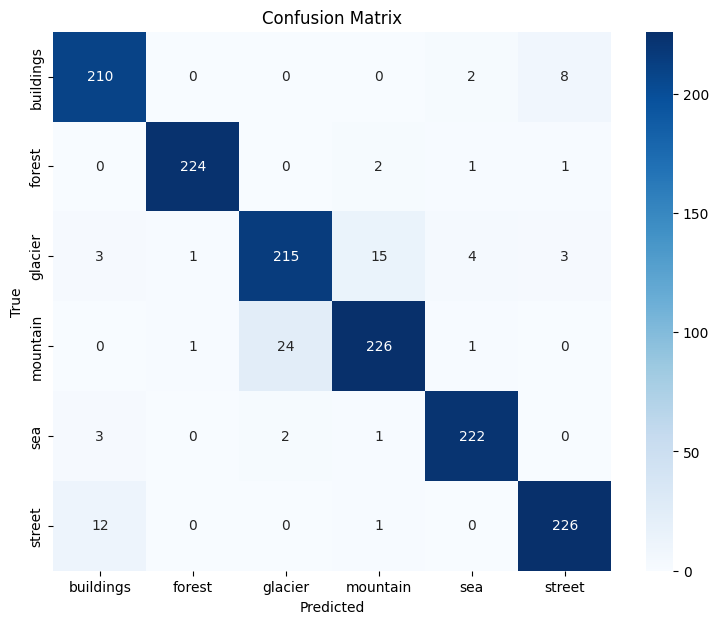

In [ ]:
# compute predictions on test set
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

all_preds = []
all_targs = []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        preds = torch.argmax(logits, dim=1).cpu().numpy().tolist()
        all_preds.extend(preds)
        all_targs.extend(labels.numpy().tolist())

print("Accuracy:", accuracy_score(all_targs, all_preds))
print("\nClassification report:\n")
print(classification_report(all_targs, all_preds, target_names=class_names))

# confusion matrix heatmap
import matplotlib.pyplot as plt
import seaborn as sns
cm = confusion_matrix(all_targs, all_preds)
plt.figure(figsize=(9,7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

# Utility: find last Conv2d module name & module
def find_last_conv_module(model):
    last_name, last_mod = None, None
    for name, m in model.named_modules():
        if isinstance(m, torch.nn.Conv2d):
            last_name, last_mod = name, m
    return last_name, last_mod

last_conv_name, last_conv_mod = find_last_conv_module(model)
print("Last conv layer:", last_conv_name)

# Grad-CAM helper class
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.model.eval()
        self.device = next(model.parameters()).device
        self.activation = None
        self.gradients = None
        # register hooks on target layer
        for name, module in self.model.named_modules():
            if name == target_layer_name:
                module.register_forward_hook(self.save_activation)
                module.register_full_backward_hook(self.save_gradient)
                break
        if target_layer_name is None:
            raise ValueError("target_layer_name not found in model")

    def save_activation(self, module, input, output):
        # output: (N, C, H, W)
        self.activation = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        # grad_output is a tuple
        self.gradients = grad_output[0].detach()

    def compute(self, input_tensor, class_idx=None):
        """
        input_tensor: (1,3,H,W) preprocessed and on device
        class_idx: target class index to explain. If None, uses top1 prediction.
        returns heatmap (H,W) normalized between 0-1
        """
        self.model.zero_grad()
        output = self.model(input_tensor)  # forward
        if class_idx is None:
            class_idx = int(output.argmax(dim=1).item())
        loss = output[0, class_idx]
        loss.backward(retain_graph=True)

        # grads: (N, C, H, W); acts: (N, C, H, W)
        grads = self.gradients[0]      # (C, H, W)
        acts = self.activation[0]      # (C, H, W)

        # global average pooling of grads -> weights
        weights = grads.mean(dim=(1,2))  # (C,)

        # weighted sum of activation maps
        cam = (weights[:, None, None] * acts).sum(dim=0)  # (H, W)
        cam = F.relu(cam)
        cam_np = cam.cpu().numpy()
        # normalize
        cam_np -= cam_np.min()
        if cam_np.max() != 0:
            cam_np /= cam_np.max()
        # resize to input size (H_in, W_in)
        cam_np = cv2.resize(cam_np, (input_tensor.shape[3], input_tensor.shape[2]))
        return cam_np, class_idx

# overlay function
def overlay_heatmap_on_image(img_pil, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    """
    img_pil: PIL.Image (size W,H)
    heatmap: numpy array (H,W) normalized 0-1
    """
    img = np.array(img_pil)[:,:,::-1]  # RGB->BGR for cv2
    hmap = np.uint8(255 * heatmap)
    hmap = cv2.applyColorMap(hmap, colormap)
    hmap = cv2.resize(hmap, (img.shape[1], img.shape[0]))
    overlay = cv2.addWeighted(hmap, alpha, img, 1-alpha, 0)
    overlay = overlay[:,:,::-1]  # BGR->RGB
    return overlay

# create GradCAM object
gradcam = GradCAM(model, last_conv_name)
print("GradCAM ready.")


Last conv layer: conv_head
GradCAM ready.


Sample images: 12


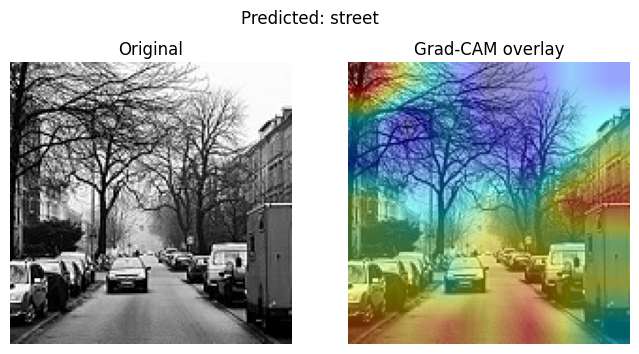

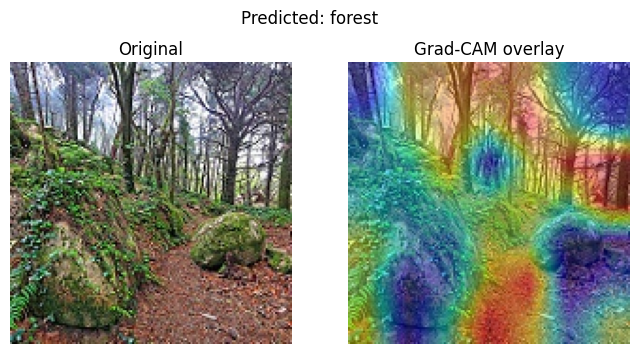

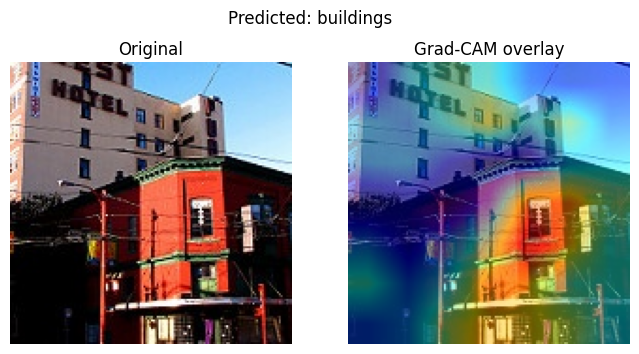

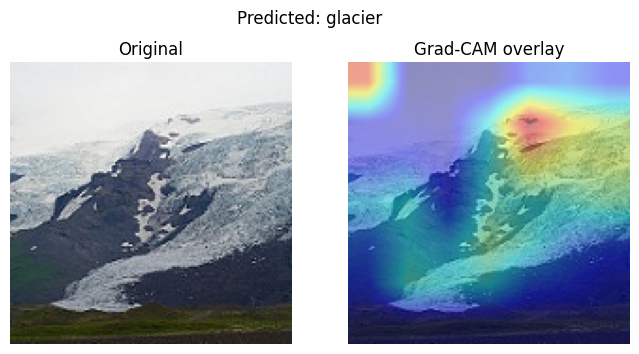

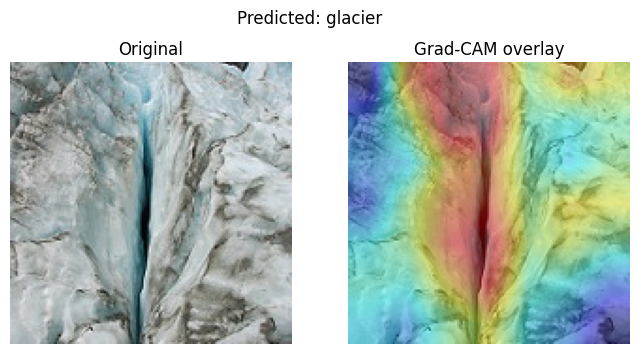

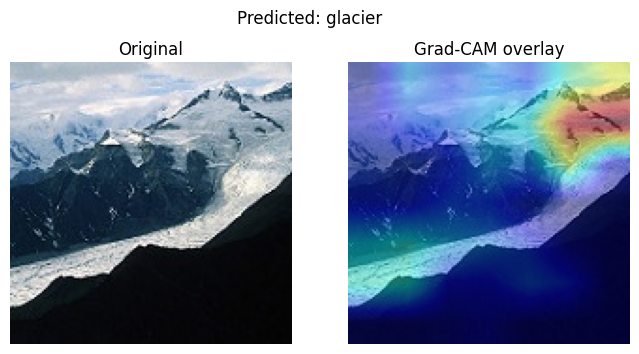

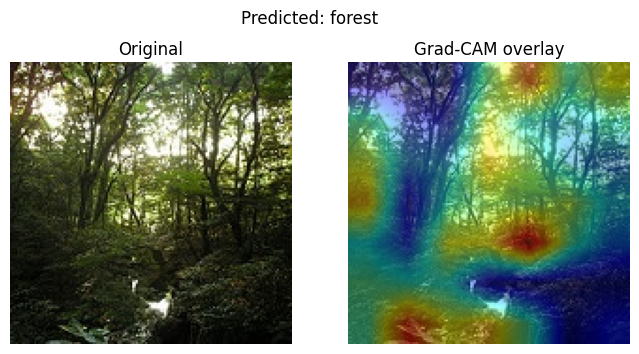

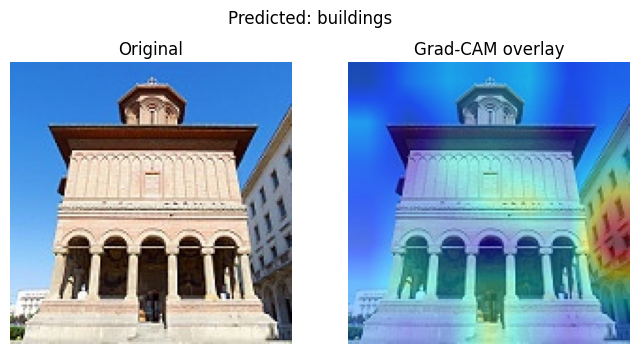

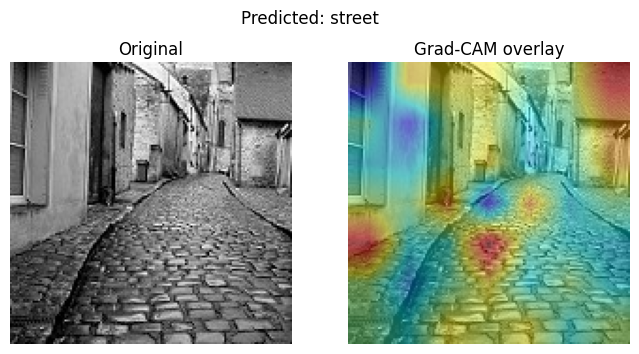

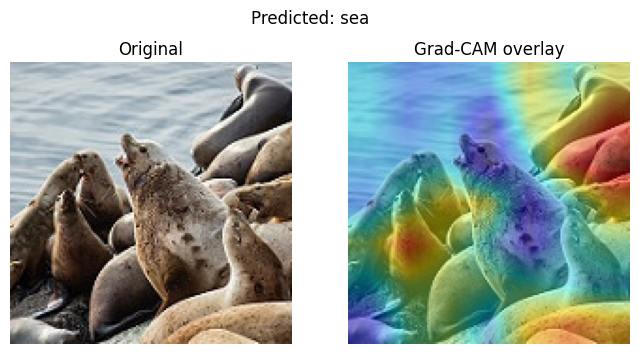

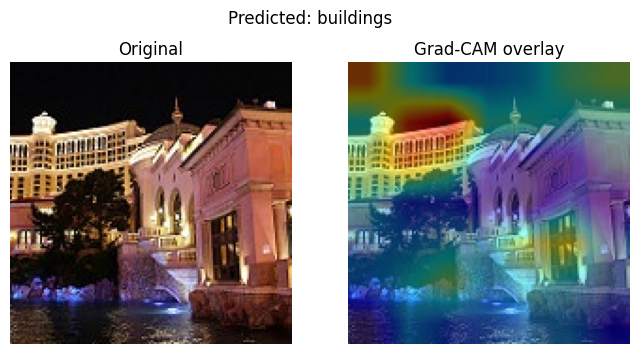

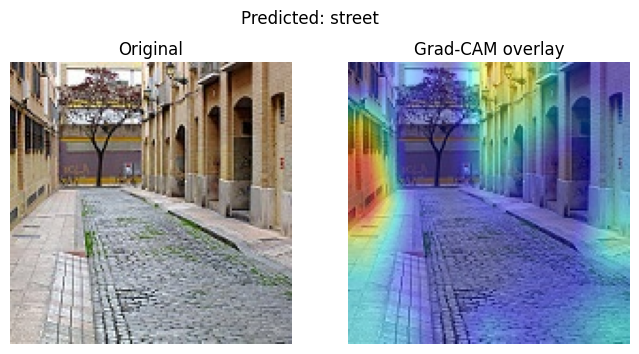

In [ ]:
import random
from torchvision.transforms import functional as TF
from PIL import Image

# Pick some test image paths (randomly sample a few)
test_root = os.path.join(DATA_DIR, 'test')
all_image_paths = []
for cls in class_names:
    p = os.path.join(test_root, cls)
    if os.path.isdir(p):
        all_image_paths += [os.path.join(p, f) for f in os.listdir(p) if f.lower().endswith(('.jpg','.png','.jpeg'))]

random.seed(42)
sample_paths = random.sample(all_image_paths, min(12, len(all_image_paths)))
print("Sample images:", len(sample_paths))

def preprocess_for_model(img_path):
    img = Image.open(img_path).convert('RGB')
    x = val_tfm(img).unsqueeze(0).to(DEVICE)  # shape (1,3,H,W)
    return img, x

# Display function
def show_gradcam_on_path(path):
    orig_img, inp = preprocess_for_model(path)
    heatmap, class_idx = gradcam.compute(inp, class_idx=None)  # top1 by default
    pred_label = class_names[class_idx]
    overlay = overlay_heatmap_on_image(orig_img, heatmap)
    # plot
    plt.figure(figsize=(8,4))
    plt.suptitle(f"Predicted: {pred_label}")
    plt.subplot(1,2,1)
    plt.imshow(orig_img); plt.axis('off'); plt.title('Original')
    plt.subplot(1,2,2)
    plt.imshow(overlay); plt.axis('off'); plt.title('Grad-CAM overlay')
    plt.show()

# Run for sample images
for p in sample_paths:
    show_gradcam_on_path(p)


In [ ]:
OUT_DIR = '/content/gradcam_results'
os.makedirs(OUT_DIR, exist_ok=True)
for i,p in enumerate(sample_paths):
    orig_img, inp = preprocess_for_model(p)
    heatmap, class_idx = gradcam.compute(inp, class_idx=None)
    overlay = overlay_heatmap_on_image(orig_img, heatmap)
    out_path = os.path.join(OUT_DIR, f"gradcam_{i}_{class_names[class_idx]}.png")
    from PIL import Image
    Image.fromarray((overlay).astype('uint8')).save(out_path)
print("Saved Grad-CAM images to", OUT_DIR)


Saved Grad-CAM images to /content/gradcam_results


In [ ]:
#phase 2

In [ ]:
# Phase-2 Report generator (Colab)
# - recomputes test metrics & confusion matrix
# - regenerates Grad-CAM images (a few samples)
# - creates a PDF report at /content/scene_recog_report.pdf
# REQUIREMENTS: timm, reportlab, matplotlib, seaborn, opencv-python
!pip install -q timm==0.9.2 reportlab seaborn opencv-python-headless

import os, torch, timm, copy, random
import numpy as np
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from reportlab.lib.pagesizes import A4
from reportlab.pdfgen import canvas
from reportlab.lib.utils import ImageReader
import cv2
from PIL import Image
import torch.nn.functional as F

# CONFIG - adjust if your paths differ
DATA_DIR = '/content/dataset_split'   # train/val/test created earlier
CHECKPOINT = '/content/best_model.pth'
IMG_SIZE = 224
BATCH = 32
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
OUT_DIR = '/content/report_assets'
os.makedirs(OUT_DIR, exist_ok=True)

# Load model + classes
ckpt = torch.load(CHECKPOINT, map_location=DEVICE)
class_names = ckpt.get('class_names', None)
if class_names is None:
    class_names = sorted([d for d in os.listdir(os.path.join(DATA_DIR,'train')) if os.path.isdir(os.path.join(DATA_DIR,'train',d))])
model = timm.create_model('tf_efficientnet_b0_ns', pretrained=False, num_classes=len(class_names))
model.load_state_dict(ckpt['model_state'])
model.to(DEVICE)
model.eval()

# transforms
val_tfm = transforms.Compose([
    transforms.Resize(int(IMG_SIZE*1.15)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_ds = datasets.ImageFolder(os.path.join(DATA_DIR,'test'), transform=val_tfm)
test_loader = DataLoader(test_ds, batch_size=BATCH, shuffle=False, num_workers=2, pin_memory=True)

# 1) Evaluate & save classification report + confusion matrix image
all_preds, all_targs = [], []
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(DEVICE)
        logits = model(imgs)
        preds = logits.argmax(1).cpu().numpy().tolist()
        all_preds.extend(preds)
        all_targs.extend(labels.cpu().numpy().tolist())

acc = accuracy_score(all_targs, all_preds)
cls_report = classification_report(all_targs, all_preds, target_names=class_names, digits=4)
cm = confusion_matrix(all_targs, all_preds)

# save confusion matrix figure
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title(f'Confusion Matrix (acc={acc:.4f})')
cm_path = os.path.join(OUT_DIR, 'confusion_matrix.png')
plt.tight_layout(); plt.savefig(cm_path, dpi=200); plt.close()

# 2) Grad-CAM: find last conv automatically and make a few overlays
def find_last_conv_module(model):
    last_name, last_mod = None, None
    for name, m in model.named_modules():
        if isinstance(m, torch.nn.Conv2d):
            last_name, last_mod = name, m
    return last_name

last_conv_name = find_last_conv_module(model)
print("Detected last conv layer:", last_conv_name)

# register hooks
activation = None; gradients = None
def forward_hook(module, inp, out):
    global activation; activation = out.detach()
def backward_hook(module, grad_in, grad_out):
    global gradients; gradients = grad_out[0].detach()

# attach hooks to the module object
for name, module in model.named_modules():
    if name == last_conv_name:
        module.register_forward_hook(forward_hook)
        module.register_full_backward_hook(backward_hook)
        break

# helper to compute grad-cam heatmap
def compute_gradcam_for_tensor(x_tensor, class_idx=None):
    global activation, gradients
    activation = None; gradients = None
    model.zero_grad()
    out = model(x_tensor)
    if class_idx is None:
        class_idx = int(out.argmax(dim=1).item())
    loss = out[0, class_idx]
    loss.backward(retain_graph=True)
    grads = gradients[0]   # C,H,W
    acts = activation[0]   # C,H,W
    weights = grads.mean(dim=(1,2))  # C
    cam = (weights[:,None,None] * acts).sum(dim=0)  # H,W
    cam = F.relu(cam).cpu().numpy()
    cam -= cam.min()
    if cam.max()!=0:
        cam /= cam.max()
    cam_resized = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
    return cam_resized, class_idx

# pick sample images from test set (up to 8)
test_root = os.path.join(DATA_DIR, 'test')
all_paths = []
for cls in class_names:
    p = os.path.join(test_root, cls)
    if os.path.isdir(p):
        for f in os.listdir(p):
            if f.lower().endswith(('.jpg','.png','.jpeg')):
                all_paths.append(os.path.join(p, f))
random.seed(42)
sample_paths = random.sample(all_paths, min(8, len(all_paths)))

gradcam_paths = []
for i, pth in enumerate(sample_paths):
    img_pil = Image.open(pth).convert('RGB')
    x = val_tfm(img_pil).unsqueeze(0).to(DEVICE)
    cam, cls_idx = compute_gradcam_for_tensor(x, class_idx=None)
    pred_label = class_names[cls_idx]
    # overlay
    img_cv = cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)
    heatmap = np.uint8(255 * cam)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
    overlay = cv2.addWeighted(heatmap, 0.5, img_cv, 0.5, 0)
    overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
    out_path = os.path.join(OUT_DIR, f'gradcam_{i}_{pred_label}.png')
    Image.fromarray(overlay).save(out_path)
    gradcam_paths.append(out_path)

# 3) Build PDF with reportlab
pdf_path = '/content/scene_recog_report.pdf'
c = canvas.Canvas(pdf_path, pagesize=A4)
W, H = A4

# Title
c.setFont("Helvetica-Bold", 18)
c.drawString(40, H-60, "Deep Learning-based Scene Recognition — Report")
c.setFont("Helvetica", 10)
c.drawString(40, H-80, f"Model: EfficientNet-B0 (timm) | Checkpoint: {os.path.basename(CHECKPOINT)}")
c.drawString(40, H-95, f"Dataset split: {DATA_DIR} | Test size: {len(test_ds)} images")
c.drawString(40, H-110, f"Overall test accuracy: {acc:.4f}")

# Add classification report text (wrap)
text_y = H-130
c.setFont("Helvetica-Bold", 12)
c.drawString(40, text_y, "Classification Report (precision / recall / f1):")
text_y -= 14
c.setFont("Helvetica", 8)
# write small block of the classification report
for line in cls_report.splitlines():
    if text_y < 100:
        c.showPage(); text_y = H-60
    c.drawString(40, text_y, line[:150])
    text_y -= 10

# Add confusion matrix image
c.showPage()
c.setFont("Helvetica-Bold", 14)
c.drawString(40, H-60, "Confusion Matrix")
img = ImageReader(cm_path)
c.drawImage(img, 40, H-420, width=520, height=350, preserveAspectRatio=True)

# Add Grad-CAM images (grid)
c.showPage()
c.setFont("Helvetica-Bold", 14)
c.drawString(40, H-60, "Grad-CAM Visualizations (sample images)")
x = 40; y = H-120
max_h = 200
for i, gp in enumerate(gradcam_paths):
    if i>0 and i%2==0:
        y -= (max_h+40); x = 40
        if y < 120:
            c.showPage(); x=40; y=H-120
    img = ImageReader(gp)
    c.drawImage(img, x, y-max_h, width=260, height=max_h, preserveAspectRatio=True)
    c.drawString(x, y-max_h-12, os.path.basename(gp))
    x += 280

c.showPage()
c.setFont("Helvetica-Bold", 12)
c.drawString(40, H-60, "Notes & Next Steps")
c.setFont("Helvetica", 10)
c.drawString(40, H-80, "- Consider TTA and small ensemble for +1~2% boost if needed.")
c.drawString(40, H-95, "- For deployment: quantize with torch.quantization or export to ONNX/TorchScript.")
c.drawString(40, H-110, "- Create Streamlit demo to show predictions + Grad-CAM (app provided).")

c.save()
print("Report saved to", pdf_path)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 39.8 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:114: UserWarning: Mapping deprecated model name tf_efficientnet_b0_ns to current tf_efficientnet_b0.ns_jft_in1k.
  model = create_fn(


Detected last conv layer: conv_head
Report saved to /content/scene_recog_report.pdf


In [ ]:
from google.colab import files
files.download('/content/scene_recog_report.pdf')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
!ls -l /content


total 4
drwxr-xr-x 1 root root 4096 Oct 28 13:34 sample_data
